In [1]:
import os
import re
import pandas as pd
import math
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, Conv2DTranspose, Activation, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.utils import to_categorical
from datetime import datetime

In [2]:
image_path = r"Serial/Sent/Data/"
excel_file = r"Serial/Sent/labels.xlsx"
labels_df = pd.read_excel(excel_file)

labels_df['label'] = labels_df['label'].fillna('').astype(str)
valid_labels_df = labels_df[labels_df['label'].str.match(r'^[A-Za-z0-9]{9}$')]
labels = list(valid_labels_df['label'])
image_names = valid_labels_df["image_name"]
print(f"Rows removed: {len(labels_df) - len(valid_labels_df)}")


Rows removed: 13


In [3]:
images_list = []
image_paths = []


def Read_images(image_path, image_names):
    for image_name in image_names:
        img_path = os.path.join(image_path, image_name)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                images_list.append(img)
            else:
                print(f"Error reading image: {img_path}")

Read_images(image_path, image_names)


X_train_val, X_test, y_train_val, y_test = train_test_split(images_list, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1088
Validation set size: 272
Test set size: 340


In [4]:
#Pre-processing

def estimate_noise_std(image):
    coeffs = pywt.dwt2(image, wavelet='db1')
    _, (cH, cV, cD) = coeffs  
    detail_coeffs = np.concatenate([cH.ravel(), cV.ravel(), cD.ravel()])
    mad = np.median(np.abs(detail_coeffs - np.median(detail_coeffs)))
    noise_std = mad / 0.6745
    return noise_std

def wavelet_denoising(img, wavelet='db1', level=2, threshold_value=20):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]

    def thresholding(coeff, threshold):
        return pywt.threshold(coeff, threshold, mode='soft')

    cH = thresholding(cH, threshold_value)
    cV = thresholding(cV, threshold_value)
    cD = thresholding(cD, threshold_value)
    coeffs[1] = (cH, cV, cD)
    denoised_img = pywt.waverec2(coeffs, wavelet=wavelet)
    denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)

    return denoised_img

def find_and_sort_contours(img, min_area, block_size=39, C=15, wavelet_mode='db1'):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_std = estimate_noise_std(img)
    threshold_value = noise_std * np.sqrt(2.25 * np.log(img.size))
    img = wavelet_denoising(img, wavelet=wavelet_mode, level=4, threshold_value=threshold_value)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C)
    
    num_labels, labels = cv2.connectedComponents(img)
    valid_contours = []
    for i in range(1, num_labels):  
        component_mask = (labels == i).astype(np.uint8) * 255
        component_contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(component_contours) == 1: 
            contour = component_contours[0]
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h

            if min_area <= area and 0.2 < aspect_ratio < 1.3: 
                valid_contours.append(contour)

    valid_contours = sorted(valid_contours, key=lambda contour: cv2.boundingRect(contour)[0])
    return valid_contours, len(valid_contours)

In [5]:
# Hyperparameters
wavelet_types = ['db1', 'sym4']
threshold_modes = ['soft', 'hard']
levels = [3, 4]
adaptive_threshold_types = [cv2.ADAPTIVE_THRESH_GAUSSIAN_C]
C_values = range(10, 21, 2)  
block_sizes = range(35, 47, 2)

wavelet_types = ['db1', 'sym4']
threshold_modes = ['soft']
levels = [3, 4]
adaptive_threshold_types = [cv2.ADAPTIVE_THRESH_GAUSSIAN_C]
C_values = range(15, 19, 2)
block_sizes = range(39, 45, 2)

param_combinations = list(itertools.product(wavelet_types, threshold_modes, levels, adaptive_threshold_types, C_values, block_sizes))

def evaluate_parameters(wavelet, mode, level, adaptive_thresh_type, C_value, block_size, img):
    noise_std = estimate_noise_std(img)
    threshold_value = noise_std * np.sqrt(2.25 * np.log(img.size))
    img_denoised = wavelet_denoising(img, wavelet=wavelet, level=level, threshold_value=threshold_value)
    img_thresholded = cv2.adaptiveThreshold(img_denoised, 255, adaptive_thresh_type, cv2.THRESH_BINARY_INV, block_size, C_value)
    valid_contours, valid_contour_count = find_and_sort_contours(img_thresholded, min_area=9)
    return valid_contour_count


def grid_search(param_combinations, images):
    successful_combinations = {comb: 0 for comb in param_combinations}
    
    total_combinations = len(param_combinations) * len(images)
    current_progress = 0
    
    for params in param_combinations:
        wavelet, mode, level, adaptive_thresh_type, C_value, block_size = params
        for idx, img in enumerate(images):
            current_progress += 1
            print(f"Testing hyperparameters: {params} | Progress: {current_progress}/{total_combinations}")
            
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            valid_contour_count = evaluate_parameters(wavelet, mode, level, adaptive_thresh_type, C_value, block_size, img)
            if valid_contour_count == 9:
                successful_combinations[params] += 1
    
    best_combination = max(successful_combinations, key=successful_combinations.get)
    best_count = successful_combinations[best_combination]
    return best_combination, best_count

# Running grid search
#best_combination, best_count = grid_search(param_combinations, X_train)
#print(f"Best parameter combination: {best_combination} with {best_count} successful detections of exactly 9 contours")
# Best parameter combination: ('db1', 'soft', 4, 1, 15, 39) with 0 successful detections of exactly 9 contours

In [13]:
# Encode and evaluate
def evaluate_contours(images, labels, print_text):
    imgs = []
    invalid_indexes_and_labels = []  
    for idx, (img, label) in enumerate(zip(images, labels)):
        valid_contours, valid_contour_count = find_and_sort_contours(img, 9)      
        if valid_contour_count == 9:
            imgs.append(img)
            invalid_indexes_and_labels.append((idx, label, valid_contour_count)) 
    print(f"Number of images with valid contour count not equal to 9 for {print_text}: {len(imgs)} / {len(images)} = {(len(imgs) / len(images))*100:.2f}%")
    return imgs, invalid_indexes_and_labels, imgs

valid_idx_train = []
valid_contours_list_train = []
valid_idx_val = []
valid_contours_list_val = []
valid_idx_test = []
valid_contours_list_test = []

def Segment_chars(images, valid_idx, valid_contours_list):
    for idx, img in enumerate(images):  
        valid_contours, valid_contour_count = find_and_sort_contours(img, 9)      
        if valid_contour_count == 9:
            valid_idx.append(idx)
            valid_contours_list.append(np.array(valid_contours, dtype=object))

Segment_chars(X_train, valid_idx_train, valid_contours_list_train)
Segment_chars(X_val, valid_idx_val, valid_contours_list_val)
Segment_chars(X_test, valid_idx_test, valid_contours_list_test)



def Encode_labels(labels):
    result = []  
    for label in labels:
        char_list = []
        for c in label:
            if '0' <= c <= '9':
                char_list.append(ord(c) - ord('0'))
            elif 'A' <= c <= 'Z':
                char_list.append(ord(c) - ord('A') + 10)
            else:
                print(f"Invalid character detected in label: {label}")     
        result.append(np.array(char_list))  
    return result

Encoded_labels_train = Encode_labels([y_train[i] for i in valid_idx_train])
Encoded_labels_val = Encode_labels([y_val[i] for i in valid_idx_val])
Encoded_labels_test = Encode_labels([y_test[i] for i in valid_idx_test])


for i in range(min(1, len(valid_idx_train))):
    print(f"-Label: {y_train[valid_idx_train[i]]} || -Encoding: {Encoded_labels_train[i]}")

test = ['09AZ']
print(f"Label: {test} || -Encoding: {Encode_labels(test)}")


-Label: IE8977447 || -Encoding: [18 14  8  9  7  7  4  4  7]
Label: ['09AZ'] || -Encoding: [array([ 0,  9, 10, 35])]


Number of images with valid contour count not equal to 9 for train set: 32 / 1088 = 2.94%


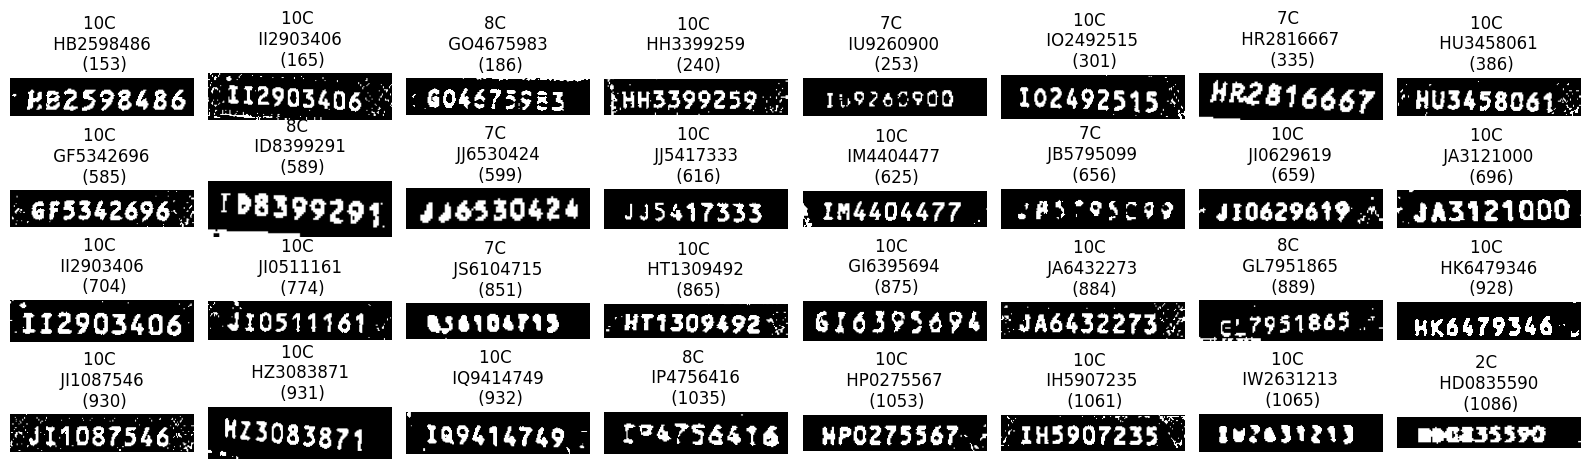

Number of images with valid contour count not equal to 9 for validation set: 12 / 272 = 4.41%


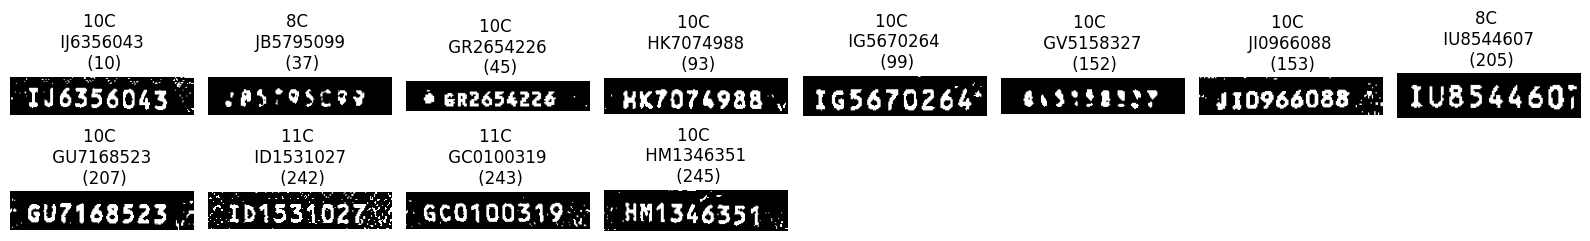

Number of images with valid contour count not equal to 9 for test set: 10 / 340 = 2.94%


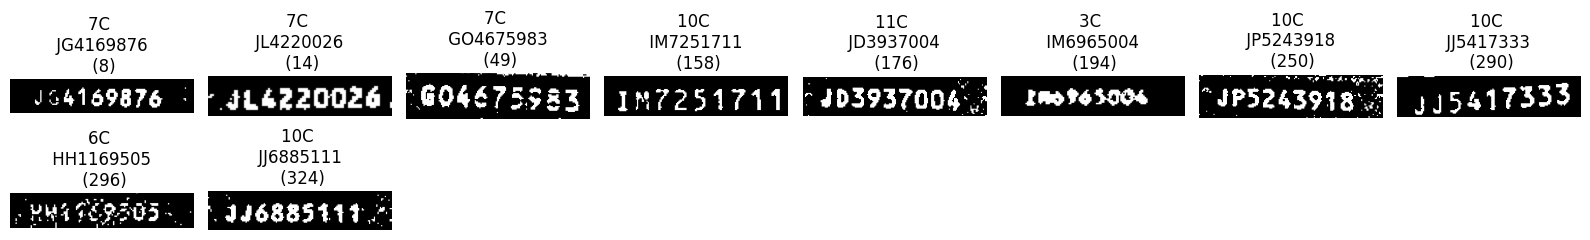

In [12]:
def plot_images_with_invalid_contours(X_data, y_data, invalid_info, imgs, title="", num_images_to_display=32, cols=8):
    indices = [info[0] for info in invalid_info]
    num_images = len(indices)
    rows = math.ceil(num_images / cols)
    
    plt.figure(figsize=(cols * 2, rows + 1)) 
    for i, idx in enumerate(indices[:num_images_to_display]):
        img = X_data[idx]
        img = imgs[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        
        noise_std = estimate_noise_std(img)    
        threshold_value = noise_std * np.sqrt(2.25 * np.log(img.size))
        img = wavelet_denoising(img, wavelet='db1', level=4, threshold_value=threshold_value)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 39, 15)
        
        name = y_data[idx]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{invalid_info[i][2]}C \n {name} \n ({idx})") 
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage for training data:
imgs_with_invalid_contours, invalid_info_train, imgs_train = evaluate_contours(X_train, y_train, 'train set')
plot_images_with_invalid_contours(X_train, y_train, invalid_info_train, imgs_train)

# Example usage for validation data:
imgs_with_invalid_contours, invalid_info_val, imgs_val = evaluate_contours(X_val, y_val, 'validation set')
plot_images_with_invalid_contours(X_val, y_val, invalid_info_val, imgs_val)

# Example usage for test data:
imgs_with_invalid_contours, invalid_info_test, imgs_test = evaluate_contours(X_test, y_test, 'test set')
plot_images_with_invalid_contours(X_test, y_test, invalid_info_test, imgs_test)


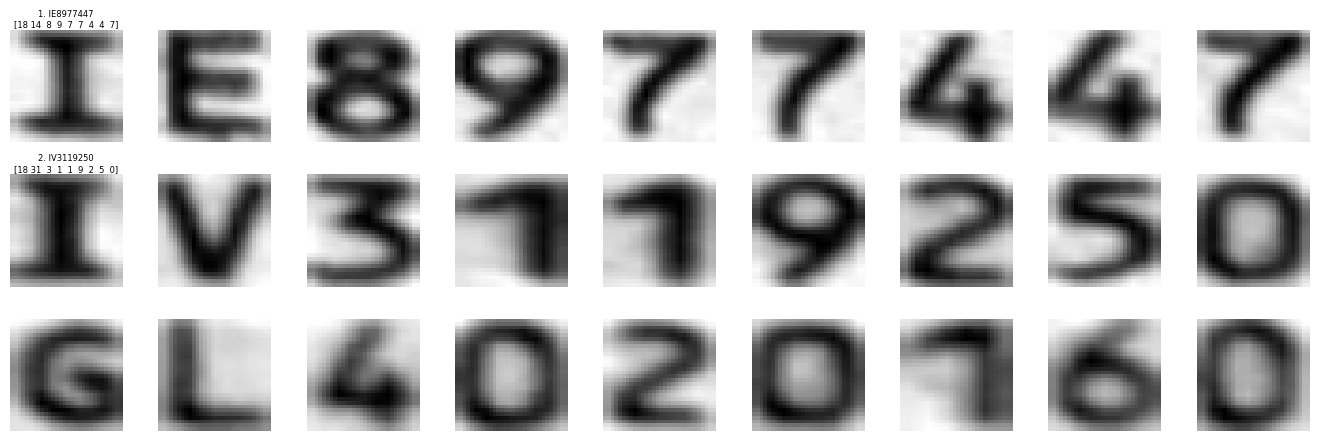

In [13]:
def plot_images_with_contours(images_list, valid_idx, labels, valid_contours_list, Encoded_labels, cols=9, max_images=100, sub_image_size=(30, 30)):
    num_images = min(len(valid_idx), max_images)  
    rows = math.ceil(num_images / cols)  
    plt.figure(figsize=(cols * 1.5, rows * 1.5))  
    subplot_idx = 1  
    
    for i, idx in enumerate(valid_idx[:num_images]):  
        img = images_list[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        name = labels[idx]
        
        sub_images = []
        for contour in valid_contours_list[i]:
            x, y, w, h = cv2.boundingRect(contour)  
            if w > 0 and h > 0:  
                sub_image = img[y:y+h, x:x+w]  
                sub_image = cv2.resize(sub_image, sub_image_size) 
                sub_images.append(sub_image)

        for sub_image in sub_images:
            if subplot_idx > rows * cols:  
                break
            plt.subplot(rows, cols, subplot_idx)
            plt.imshow(sub_image, cmap='gray')
            plt.axis('off')
            subplot_idx += 1
        
        if subplot_idx <= rows * cols:
            plt.subplot(rows, cols, subplot_idx - len(sub_images))
            plt.title(f"{i+1}. {name}\n{Encoded_labels[i]}", fontsize=6, pad=2)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_images_with_contours(X_train, valid_idx_train, y_train, valid_contours_list_train, Encoded_labels_train, cols=9, max_images=20)

In [16]:
def save_segmented_chars(images_list, valid_idx, labels, valid_contours_list, Encoded_labels, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i, idx in enumerate(valid_idx):
        img = images_list[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image_label = labels[idx]
        encoded_label = Encoded_labels[i]
        
        image_folder = os.path.join(save_path, f"image_{idx}_{image_label}")
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        
        sorted_contours_with_boxes = sorted(
            [(contour, cv2.boundingRect(contour)) for contour in valid_contours_list[i]],
            key=lambda item: item[1][0]
        )
        
        for char_idx, (contour, (x, y, w, h)) in enumerate(sorted_contours_with_boxes):
            if w > 0 and h > 0:
                char_image = img[y:y+h, x:x+w]
                char_image_resized = cv2.resize(char_image, (30, 30))
                
                char = chr(encoded_label[char_idx] + ord('0')) if encoded_label[char_idx] < 10 else chr(encoded_label[char_idx] - 10 + ord('A'))
                
                char_filename = os.path.join(image_folder, f"{char_idx + 1}_{char}.jpg")
                cv2.imwrite(char_filename, char_image_resized)

        print(f"Saved segmented characters for image {idx} with label '{image_label}'")

save_path = "segmented_chars/train"  
save_segmented_chars(X_train, valid_idx_train, y_train, valid_contours_list_train, Encoded_labels_train, save_path)

save_path = "segmented_chars/val"  
save_segmented_chars(X_val, valid_idx_val, y_val, valid_contours_list_val, Encoded_labels_val, save_path)

save_path = "segmented_chars/test"  
save_segmented_chars(X_test, valid_idx_test, y_test, valid_contours_list_test, Encoded_labels_test, save_path)


Saved segmented characters for image 0 with label 'IE8977447'
Saved segmented characters for image 1 with label 'IV3119250'
Saved segmented characters for image 2 with label 'GL4020160'
Saved segmented characters for image 3 with label 'GJ4996876'
Saved segmented characters for image 4 with label 'HQ0685914'
Saved segmented characters for image 5 with label 'JD3425363'
Saved segmented characters for image 6 with label 'IF0010428'
Saved segmented characters for image 7 with label 'IZ0783382'
Saved segmented characters for image 8 with label 'JF0847016'
Saved segmented characters for image 9 with label 'IT9391975'
Saved segmented characters for image 10 with label 'IS5029974'
Saved segmented characters for image 11 with label 'HG6744448'
Saved segmented characters for image 12 with label 'II9284030'
Saved segmented characters for image 13 with label 'JE2388181'
Saved segmented characters for image 14 with label 'IG9302297'
Saved segmented characters for image 15 with label 'HD4047946'
Sa